# Real-time MRMS Visualization

This notebook helps you visualize real-time MRMS data etc.

---

## Overview
We'll go through the steps of:

1. Region selection
2. Product and tilt selection
3. Data request
4. Visualization

---

## Imports and Formatting

In [1]:
import s3fs
import urllib
import tempfile
import gzip
import xarray as xr
import ipywidgets as widgets
import datetime
from datetime import timezone
import matplotlib.pyplot as plt
import numpy.ma as ma
from metpy.plots import ctables
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Formatting settings for drop-down menus
style = {'description_width':'120px'}
layout = widgets.Layout(width='325px')  

# Initialize the S3 filesystem as anonymous
aws = s3fs.S3FileSystem(anon=True)

# Retrieve the current datetime in UTC
now = datetime.datetime.now(datetime.UTC)
datestring = now.strftime('%Y%m%d')

## Data selection

There are numerous variables and tilts available from MRMS data. For reference, here https://www.nssl.noaa.gov/projects/mrms/operational/tables.php and here https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc

For the purpose of this notebook, I provide three options: merged reflectivity, rhohv, and zdr. 

In [3]:
# Dropdown widget to choose location
location_choice = widgets.Dropdown(options=[("ALASKA"),("CARIB"),("CONUS"),("GUAM"),("HAWAII")], description='Region:', style=style, layout=layout)
display(location_choice)

# Dropdown widget to choose tilt and product
#product_choice = widgets.Dropdown(options=[("MergedReflectivityQC"),("MergedRhoHV"),("MergedZdr")], description='Radar Product:', style=style, layout=layout)
tilt_choice =  widgets.Dropdown(options=[("00.50"),("00.75"),("01.00"),("01.25"),("01.50"),("01.75"),("02.00"),("02.25"),("02.50"),("02.75"),("03.00"),("03.50"),("04.00"),("04.50"),("05.00"),("05.50"),("06.00"),("06.50"),("07.00"),("07.50"),("08.00"),("08.50"),("09.00"),("10.00"),("11.00"),("12.00"),("13.00"),("14.00"),("15.00"),("16.00"),("17.00"),("18.00"),("19.00"),], description='Tilt:', style=style, layout=layout)
#display(product_choice)
display(tilt_choice)

Dropdown(description='Region:', layout=Layout(width='325px'), options=('ALASKA', 'CARIB', 'CONUS', 'GUAM', 'HA…

Dropdown(description='Tilt:', layout=Layout(width='325px'), options=('00.50', '00.75', '01.00', '01.25', '01.5…

## Data request
We'll actually pull in the data here. 


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(56) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(56) ignored


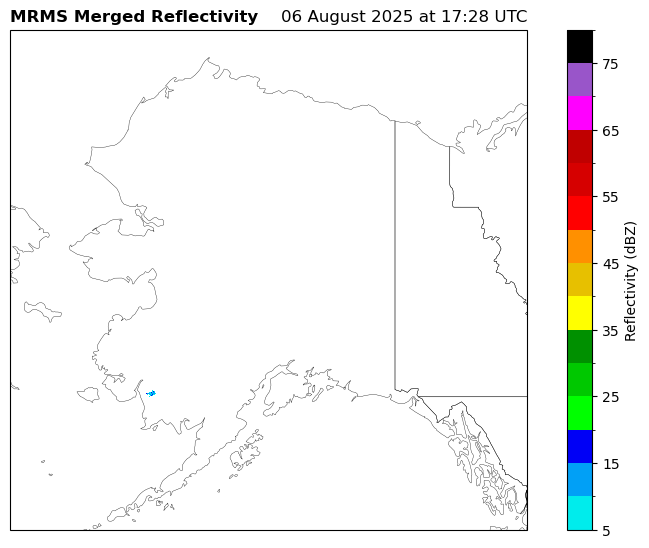

In [4]:
# Rename widget output
location = location_choice.value
tilt = tilt_choice.value
product = "MergedReflectivityQC"

# Get the selected location and tilt
data_files = aws.ls(f'noaa-mrms-pds/{location_choice.value}/MergedReflectivityQC_{tilt_choice.value}/{datestring}/', refresh=True)  
most_recent_file = data_files[-1]

# Check to see whether the most recent file is within 15 minutes of now
timestamp_str = most_recent_file.split('_')[-1].replace('.grib2.gz', '')
dt = datetime.datetime.strptime(timestamp_str, "%Y%m%d-%H%M%S").replace(tzinfo=timezone.utc)

# Check if dt is within 15 minutes of now
within_15_minutes = abs((now - dt).total_seconds()) <= 15 * 60

if within_15_minutes:
    response = urllib.request.urlopen(f"https://noaa-mrms-pds.s3.amazonaws.com/{most_recent_file[14:]}")
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(compressed_file))
        dataset = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)
        
        # Identify plotting coordinates
        lats = dataset.latitude.values
        lons = dataset.longitude.values
        vals = dataset.values
        vals_nonmiss = ma.masked_where(vals <= 0, vals)

        dataset.close()
        f.close()

    # Set Bounds
    if location == "ALASKA":
        minLat = 54    
        maxLat = 71
        minLon = -173 + 360.
        maxLon = -130 + 360.
        
    elif location == "CARIB":
        minLat = 15    
        maxLat = 21
        minLon = -70 + 360.
        maxLon = -63 + 360.
        
    elif location == "CONUS":
        minLat = 21    
        maxLat = 48
        minLon = -130 + 360.
        maxLon = -60 + 360.
        
    elif location == "GUAM":
        minLat = 11.5    
        maxLat = 15
        minLon = 146.5 
        maxLon = 143 
        
    elif location == "HAWAII":
        minLat = 18    
        maxLat = 28
        minLon = -178 + 360.
        maxLon = -154 + 360.

    title = "MRMS Merged Reflectivity"

    fig = plt.figure(num=1, figsize=(8,5), facecolor='w', edgecolor='k')
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator())
    ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
    
    # Set colors
    if product == "MergedReflectivityQC":
        ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)
        units = "Reflectivity (dBZ)"
    if product == "MergedRhoHV":
        ref_norm = None
        ref_cmap = "plasma"
        units = "RhoHV"
    if product == "MergedZdr":
        ref_norm = None
        ref_cmap = "viridis"
        units = "ZDR (dBZ)"
        
    # Add Boundaries
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

    # Plot Data
    radarplot = ax.pcolormesh(lons, lats, vals_nonmiss,transform=ccrs.PlateCarree(),cmap=ref_cmap,norm=ref_norm)
    cbar = plt.colorbar(radarplot)
    cbar.set_label(units)

    plt.title(f"{title}", loc='left', fontweight='bold')
    plt.title('{}'.format(dt.strftime('%d %B %Y at %H:%M UTC')), loc='right')

    plt.show()
    plt.close('all')